# PyTorch Cognitive Radio - Channel occupancy prediction using LSTM


>[PyTorch Cognitive Radio - Channel occupancy prediction using LSTM](#scrollTo=szOWLo_3FYsy)

>>[1. Import libraries & setup](#scrollTo=R-uOLgZWcB4I)

>>[2. Hyperparameters](#scrollTo=8-eDK_jJLcMN)

>>[3. Plotting functions](#scrollTo=T-6tgFbULffj)

>>[4. Simulate channel data](#scrollTo=gVkPvKYpLuhe)

>>[5. Sequence creation & DataLoader](#scrollTo=7-D_fGKNL6Jz)

>>[6. LSTM model definition](#scrollTo=NXTUz7rOMFLL)

>>[7. Training loop](#scrollTo=RHSHqKGMMUZw)

>>[8. Evaluate model on new dataset](#scrollTo=0AvRdlELMbBy)



## 1.&nbsp;Import libraries & setup
Imports all related libraries & installs packages (includes optional visualization libs), may require re-run after runtime restart.

In [28]:
import importlib
def ensure(pkg, pip_name=None):
    pip_name = pip_name or pkg
    try:
        importlib.import_module(pkg)
        print(f"{pkg} already installed.")
    except ImportError:
        print(f"Installing {pip_name}...")
        !pip install -q {pip_name}

ensure("torchview")
ensure("torchviz")
ensure("torch_summary", "torch-summary")
ensure("seaborn")

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from torchview import draw_graph
from torchsummary import summary


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

torchview already installed.
torchviz already installed.
Installing torch-summary...
seaborn already installed.
Using device: cuda


## 2.&nbsp;Hyperparameters
Central config dictionary - change values here

In [29]:
config = {
    'num_channels': 5,
    'signal_length': 100000,
    'input_window': 500,

    # Horizon experiment
    'horizons': [1, 2, 3, 5, 10],
    'horizon': None,
    
    'avg_duration': 40,
    'hidden_size': 64,
    'batch_size': 64,
    'num_epochs': 100,
    'learning_rate': 0.001,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

config

{'num_channels': 5,
 'signal_length': 100000,
 'input_window': 500,
 'horizons': [1, 2, 3, 5, 10],
 'horizon': None,
 'avg_duration': 40,
 'hidden_size': 64,
 'batch_size': 64,
 'num_epochs': 100,
 'learning_rate': 0.001,
 'device': device(type='cuda')}

## 3.&nbsp;Plotting functions
Contains functions that produce a plot, used later in code for data visualization.

In [30]:
# 1. Shows all 5 channels & their states
def plot_channels(channel_data, num_channels):
    plt.figure(figsize=(14, 4))

    offset = 1.5
    yticks = []
    yticklabels = []

    for i in range(num_channels):
        rev_i = num_channels - 1 - i
        channel_offset = rev_i * offset

        # Plot actual channel signal
        plt.plot(channel_data[i] + channel_offset, label=f"Channel {i+1}")

        # Add horizontal lines at 0 and 1 for this channel
        plt.hlines(y=channel_offset + 0, xmin=0, xmax=channel_data.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)
        plt.hlines(y=channel_offset + 1, xmin=0, xmax=channel_data.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)

        # Set middle point for tick
        mid = channel_offset + 0.5
        yticks.append(mid)
        yticklabels.append(f"Ch {i+1}")

    plt.title("Simulated Channel Occupancy")
    plt.xlabel("Time step")
    plt.ylabel("Occupancy")
    plt.yticks(yticks, yticklabels)
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)
    plt.grid(True)
    plt.show()


# 2. Shows heatmap sample from dataset, red = 0, green = 1
def heatmap_dataset_sample_binary(X, y, sample_index=0, input_window=100, horizon=config['horizon']):
    marker_position = input_window + horizon  # 110
    # Select the sample
    X_sample = X[sample_index]
    y_sample = y[sample_index]

    # Combine input and horizon along time axis
    combined = np.concatenate([X_sample, y_sample], axis=0).T  # shape -> (5, 110)
    plt.figure(figsize=(13, 8))

    ax = sns.heatmap(
        combined,
        cmap=["#d9534f", "#5cb85c"],
        cbar=False,
        linewidths=0.5,
        linecolor="black",
        square=True
    )
    ax.set_xlabel("Time step", fontsize=16)
    ax.set_ylabel("Channel", fontsize=16)

    # Channels
    ax.set_yticks(np.arange(combined.shape[0]) + 0.5)
    ax.set_yticklabels([str(i+1) for i in range(combined.shape[0])], fontsize=6)

    # Vertical line separating input and horizon
    ax.axvline(input_window, color="black", linewidth=4)
    ax.text(input_window + 0.5, -0.5, "←Horizon→", fontsize=10, color="black")

    # Reduce x-tick clutter
    ax.set_xticks(np.arange(0, combined.shape[1], 10))
    ax.set_xticklabels(np.arange(0, combined.shape[1], 10), rotation=90)

    # Ensure 110 is included as a tick and appears below the heatmap
    xticks = list(np.arange(0, combined.shape[1], 10))
    if marker_position not in xticks:
        xticks.append(marker_position)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(t) for t in xticks], rotation=90)

    # Thick vertical line at 110
    ax.axvline(marker_position, color='black', linewidth=3)
    plt.title(f"Dataset Sample #{sample_index}", fontsize=16, pad=20)

    # Define legend entries
    legend_elements = [
        Patch(facecolor='#d9534f', edgecolor='black', label='0'),
        Patch(facecolor='#5cb85c', edgecolor='black', label='1')
    ]
    # Add legend to the axes
    ax.legend(handles=legend_elements, title='Value', loc='upper right', bbox_to_anchor=(1.08, 1.2))
    plt.tight_layout()
    plt.show()


# 3. Shows loss curve plotted over num. of epochs
def plot_loss(loss_values, num_epochs):
    min_loss_value = min(loss_values)
    min_loss_epoch = loss_values.index(min_loss_value) + 1  # +1 because num_epochs start at 1
    max_loss_value = max(loss_values)
    last_loss_value = loss_values[num_epochs-1]
    # Loss curve plot with best loss highlighted
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', label='Training Loss')

    # Highlight the best loss
    plt.plot(min_loss_epoch, min_loss_value, 'ro', label='Best Loss')
    plt.annotate(f'Best: {min_loss_value:.4f}',
                xy=(min_loss_epoch, min_loss_value),
                xytext=(min_loss_epoch + 1, min_loss_value + 0.01),
                arrowprops=dict(facecolor='red', arrowstyle='->'))

    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 4. Compares real channel data with predicted channel data (model doesn't predict first 100 time steps)
def plot_compare_channels(X_raw, pred_full, warmup=config['input_window']):

    pred_plot = pred_full.copy()
    pred_plot[:, :warmup] = np.nan  # model doesn't predict first 100 time steps

    num_channels = X_raw.shape[0]
    fig, axes = plt.subplots(num_channels, 1, figsize=(35, 2*num_channels), sharex=False)

    for i in range(num_channels):
        ax = axes[i]

        # Solid line for actual
        ax.plot(X_raw[i], label=f"Channel {i+1} Actual", linewidth=2)

        # Dashed line for predicted
        ax.plot(pred_plot[i], '--', label=f"Channel {i+1} Predicted", linewidth=2)

        ax.set_ylabel("Occupancy")
        ax.set_ylim(-0.1, 1.1)
        ax.set_yticks([0, 1])
        ax.set_title(f"Channel {i+1}")

        # Horizontal 0/1 guide lines
        ax.hlines([0, 1], xmin=0, xmax=X_raw.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)

        # Vertical guidelines
        ax.set_xticks(np.arange(0, X_raw.shape[1]+1, 50))
        ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

        ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)
        ax.margins(x=0.01)

    axes[-1].set_xlabel("Time step")
    plt.tight_layout()
    plt.show()


# 5. Shows heatmap of first 100 predictions the model makes
def heatmap_correctness_100(X_raw, pred_full, warmup=100, steps=config['input_window']):

    X_raw_np = X_raw[:, warmup:warmup + steps]
    pred_full_np = pred_full[:, warmup:warmup + steps]

    pred_bin = (pred_full_np >= 0.5).astype(int)

    correct_matrix = (pred_bin == X_raw_np).astype(int)

    plt.figure(figsize=(16, 8))
    ax = sns.heatmap(
        correct_matrix,
        cmap=["#d9534f", "#5cb85c"],
        cbar=False,
        linewidths=0.5,
        linecolor="black",
        square=True
    )

    ax.set_xlabel("Time step", fontsize=12)
    ax.set_ylabel("Channel", fontsize=12)

    ax.set_yticks(np.arange(correct_matrix.shape[0]) + 0.5)
    ax.set_yticklabels([str(i+1) for i in range(correct_matrix.shape[0])], rotation=90, fontsize=6)

    x_ticks = list(np.arange(0, correct_matrix.shape[1], 20))
    if correct_matrix.shape[1] not in x_ticks:
        x_ticks.append(correct_matrix.shape[1])

    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(warmup + tick) for tick in x_ticks], rotation=90, fontsize=10)

    plt.title(f"Prediction Accuracy Heatmap ({warmup}–{warmup+steps} steps)", fontsize=18, pad=20)
    plt.tight_layout()
    plt.show()

## 4.&nbsp;Simulate channel data
Simulates channels - Return array shape (num_channels, length) with 0/1 occupancy.

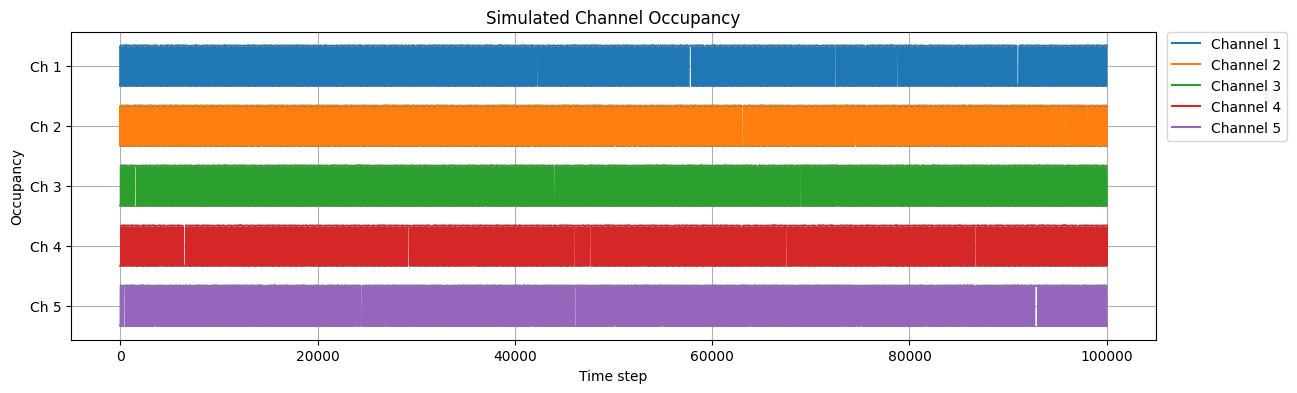

In [31]:
def simulate_multiple_channels(num_channels=config['num_channels'],
                               signal_length=config['signal_length'],
                               avg_duration=config['avg_duration']):
    channels = []
    for _ in range(num_channels):
        channel = []
        state = 0  # start with 0 or could randomize
        while len(channel) < signal_length:
            # Exponential duration for both states
            duration = np.random.exponential(scale=avg_duration)
            duration = int(max(1, round(duration)))
            channel.extend([state] * duration)
            state = 1 - state  # flip state
        # truncate to exact signal length
        channels.append(channel[:signal_length])

    return np.array(channels)

channel_data = simulate_multiple_channels()
plot_channels(channel_data, config['num_channels'])

## 5.&nbsp;Sequence creation & DataLoader
Converts channel data into X y sliding windows & creates PyTorch DataLoader

In [32]:
channel_data = simulate_multiple_channels().T  # (time_steps, num_channels)

def create_sequence(channel_data, input_window, horizon):
    """
    Creates non-overlapping sequences for a given horizon.
    
    Returns:
        X: np.array of shape (num_samples, input_window, num_channels)
        y: np.array of shape (num_samples, horizon, num_channels)
    """
    X = []
    y = []

    step = input_window + horizon  # non-overlapping
    max_start = len(channel_data) - step + 1

    for i in range(0, max_start, step):
        X.append(channel_data[i : i + input_window])
        y.append(channel_data[i + input_window : i + step])

    return np.array(X), np.array(y)


# If config['horizons'] contains multiple horizons
X_horizons = {}
y_horizons = {}

for horizon in config['horizons']:  # e.g., [1,2,3,5,10]
    X, y = create_sequence(channel_data, input_window=config['input_window'], horizon=horizon)
    print(f"Horizon={horizon}: X.shape={X.shape}, y.shape={y.shape}")
    
    # Store sequences in dictionaries
    X_horizons[horizon] = X
    y_horizons[horizon] = y

# Example: create DataLoaders for a specific horizon (say 1)
h = 1
X_tensor = torch.tensor(X_horizons[h], dtype=torch.float32)
y_tensor = torch.tensor(y_horizons[h], dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)


Horizon=1: X.shape=(199, 500, 5), y.shape=(199, 1, 5)
Horizon=2: X.shape=(199, 500, 5), y.shape=(199, 2, 5)
Horizon=3: X.shape=(198, 500, 5), y.shape=(198, 3, 5)
Horizon=5: X.shape=(198, 500, 5), y.shape=(198, 5, 5)
Horizon=10: X.shape=(196, 500, 5), y.shape=(196, 10, 5)


In [33]:
# Show heatmap sample from dataset
#heatmap_dataset_sample_binary(X, y, sample_index=0)


## 6.&nbsp;LSTM model definition
Defines the LSTM model

In [34]:
class LSTM_model(nn.Module):
    def __init__(self, num_channels, horizon, hidden_size):
        super().__init__()

        self.horizon = horizon  # number of future time steps to predict
        self.num_channels = num_channels  # number of channels/features per time step

        self.lstm = nn.LSTM(  # defines the LSTM layer:
            input_size=num_channels,  # input_size = num_channels:
                                     # dimensionality of each input vector per time step (e.g., 5 channels)
            hidden_size=hidden_size,  # hidden_size = hidden_size:
                                      # dimensionality of the LSTM hidden state
            batch_first=True          # batch_first=True:
                                      # input/output tensors are shaped as (batch, seq_len, features)
        )

        self.fc = nn.Linear(  # defines the fully connected (Linear) layer:
            hidden_size,      # maps from the final LSTM hidden state (hidden_size)
            num_channels * horizon  # to horizon future steps for each channel
        )

    def forward(self, x):
        # x shape: (batch_size, input_window, num_channels)
        out, _ = self.lstm(x)      # out: (batch_size, input_window, hidden_size)
        last_out = out[:, -1, :]   # take the last time step:
                                   # last_out: (batch_size, hidden_size)

        preds = self.fc(last_out)  # preds: (batch_size, num_channels * horizon)

        preds = preds.view(
            -1,
            self.horizon,
            self.num_channels
        )                           # reshape to:
                                    # (batch_size, horizon, num_channels)

        return torch.sigmoid(preds)  # sigmoid to output probabilities in range [0,1]


## 7.&nbsp;Training loop
Training loop for model

In [35]:
# Dictionary to store all trained models, best states, and loss histories
trained_models = {}  # {horizon: model}
best_states = {}     # {horizon: best_model_state}
best_losses = {}     # {horizon: best_loss}
loss_histories = {}  # {horizon: [loss per epoch]}

# Generate channel data once
channel_data = simulate_multiple_channels().T  # shape: (time_steps, num_channels)

for h in config['horizons']:
    print(f"\n=== Training model for horizon = {h} ===")

    # Create non-overlapping sequences for this horizon
    X, y = create_sequence(
        channel_data,
        input_window=config['input_window'],
        horizon=h
    )
    print(f"X.shape = {X.shape}, y.shape = {y.shape}")

    # DataLoader
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)

    # Initialize model
    model = LSTM_model(
        num_channels=config['num_channels'],
        horizon=h,
        hidden_size=config['hidden_size']
    ).to(config['device'])

    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.BCELoss()

    # Track best model
    best_loss = float('inf')
    best_model_state = None
    loss_values = []

    # Training loop
    for epoch in range(1, config['num_epochs'] + 1):
        model.train()
        epoch_loss = 0.0

        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(config['device'])
            y_batch = y_batch.to(config['device'])

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * X_batch.size(0)

        avg_loss = epoch_loss / len(dataset)
        loss_values.append(avg_loss)
        print(f"Epoch {epoch}/{config['num_epochs']} - Loss: {avg_loss:.4f}", flush=True)

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict()

    # Load best model
    model.load_state_dict(best_model_state)
    print(f"Training complete for horizon {h}. Best loss: {best_loss:.4f}")

    # Save everything for this horizon
    trained_models[h] = model
    best_states[h] = best_model_state
    best_losses[h] = best_loss
    loss_histories[h] = loss_values



=== Training model for horizon = 1 ===
X.shape = (199, 500, 5), y.shape = (199, 1, 5)
Epoch 1/100 - Loss: 0.6945
Epoch 2/100 - Loss: 0.6885
Epoch 3/100 - Loss: 0.6832
Epoch 4/100 - Loss: 0.6774
Epoch 5/100 - Loss: 0.6710
Epoch 6/100 - Loss: 0.6632
Epoch 7/100 - Loss: 0.6534
Epoch 8/100 - Loss: 0.6399
Epoch 9/100 - Loss: 0.6224
Epoch 10/100 - Loss: 0.6006
Epoch 11/100 - Loss: 0.5806
Epoch 12/100 - Loss: 0.5589
Epoch 13/100 - Loss: 0.5423
Epoch 14/100 - Loss: 0.5249
Epoch 15/100 - Loss: 0.5061
Epoch 16/100 - Loss: 0.4899
Epoch 17/100 - Loss: 0.4762
Epoch 18/100 - Loss: 0.4636
Epoch 19/100 - Loss: 0.4526
Epoch 20/100 - Loss: 0.4483
Epoch 21/100 - Loss: 0.4380
Epoch 22/100 - Loss: 0.4300
Epoch 23/100 - Loss: 0.4194
Epoch 24/100 - Loss: 0.4089
Epoch 25/100 - Loss: 0.4037
Epoch 26/100 - Loss: 0.3939
Epoch 27/100 - Loss: 0.3847
Epoch 28/100 - Loss: 0.3801
Epoch 29/100 - Loss: 0.3762
Epoch 30/100 - Loss: 0.3703
Epoch 31/100 - Loss: 0.3589
Epoch 32/100 - Loss: 0.3533
Epoch 33/100 - Loss: 0.345

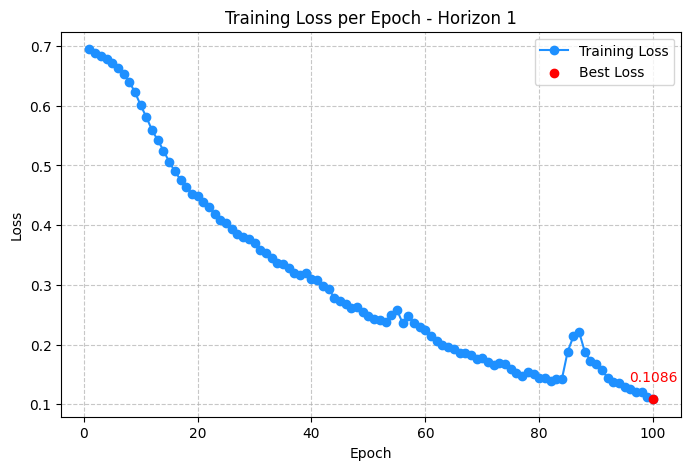

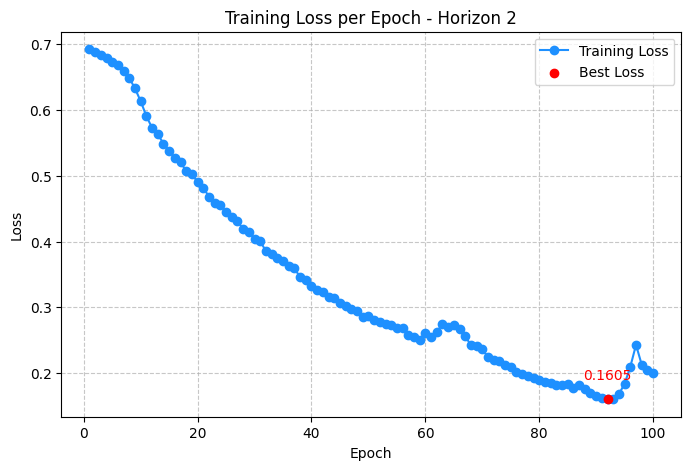

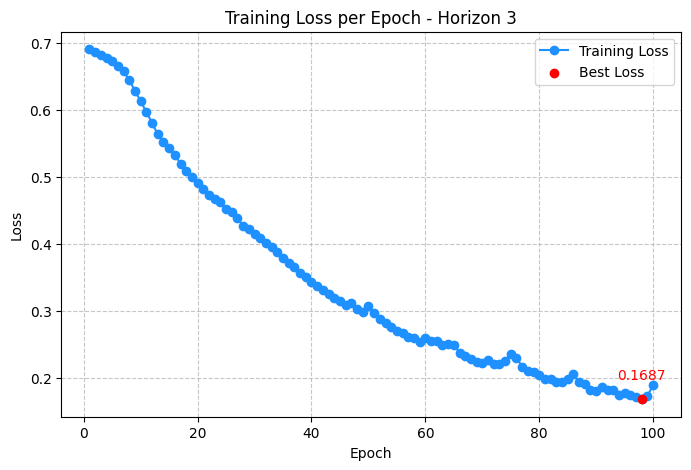

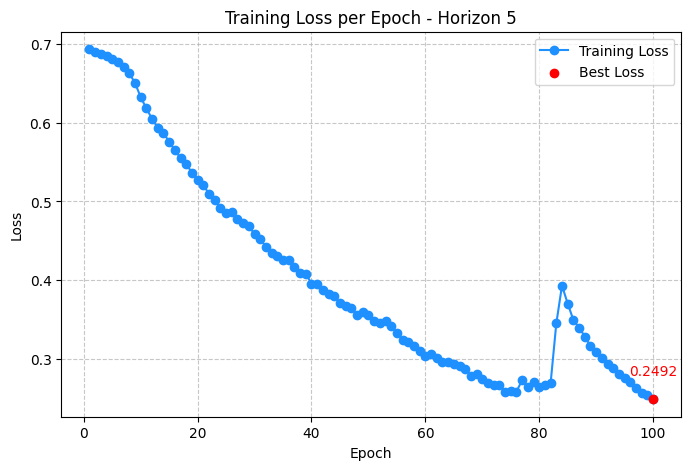

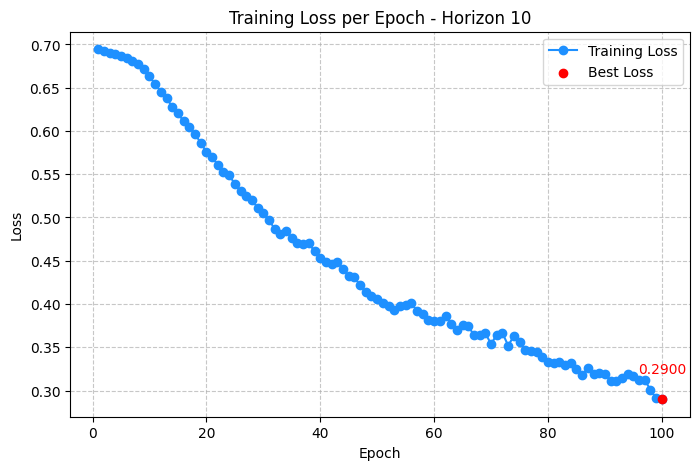

In [36]:
def plot_training_loss(loss_values, horizon, figsize=(8, 5), offset=0.03):
    """
    Plots the training loss over epochs for a single horizon,
    marking the best (lowest) loss with a red dot and annotation.

    Args:
        loss_values: list of float
            Training loss per epoch.
        horizon: int
            Horizon value for the model (used in the title).
        figsize: tuple
            Size of the figure (width, height).
        offset: float
            Vertical offset for the annotation in data units (y-axis units).
    """
    plt.figure(figsize=figsize)
    epochs = range(1, len(loss_values) + 1)

    # Plot loss curve
    plt.plot(epochs, loss_values, marker='o', color='dodgerblue', label='Training Loss')

    # Best loss
    best_loss = min(loss_values)
    best_epoch = loss_values.index(best_loss) + 1

    # Mark best loss
    plt.scatter(best_epoch, best_loss, color='red', zorder=5, label='Best Loss')
    plt.annotate(f'{best_loss:.4f}',
                 xy=(best_epoch, best_loss),
                 xytext=(best_epoch, best_loss + offset),
                 ha='center',
                 color='red')

    # Labels and styling
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per Epoch - Horizon {horizon}')
    plt.grid(linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


for h in config['horizons']:
    plot_training_loss(loss_histories[h], horizon=h)


## 8.&nbsp;Evaluate model on new dataset
Evaluates the trained model on new dataset using the same `avg_on_duration` & `avg_off_duration` values used during training, then on multiple (num_tests) new datasets (generated using `simulate_multiple_channels`)

In [37]:
# -----------------------------
# Multi-Horizon Evaluation Cell
# -----------------------------

def generate_test_data(avg_duration=None, horizon=None):
    """
    Generates test sequences for evaluation.
    
    Args:
        avg_duration: int or None
            - If None, generate random avg_duration between 1 and 100.
            - If int, use this value.
        horizon: int, required
            - Number of future steps to predict (sequence length for y)
    
    Returns:
        test_X_tensor: torch.Tensor (num_samples, input_window, num_channels)
        test_y_tensor: torch.Tensor (num_samples, horizon, num_channels)
        X_raw_T: numpy array (time_steps, num_channels)
        avg_duration_used: int
    """
    if avg_duration is None:
        avg_duration_used = random.randint(1, 100)
    else:
        avg_duration_used = avg_duration

    # Generate raw channel data
    X_raw = simulate_multiple_channels(
        num_channels=config['num_channels'],
        signal_length=config['signal_length'],
        avg_duration=avg_duration_used
    )
    X_raw_T = X_raw.T

    # Create sequences
    test_X, test_y = create_sequence(
        X_raw_T,
        input_window=config['input_window'],
        horizon=horizon
    )

    # Convert to tensors
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(config['device'])
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(config['device'])

    return test_X_tensor, test_y_tensor, X_raw_T, avg_duration_used


def reconstruct_full_prediction(preds_binary, X_raw_T, horizon):
    """
    Reconstruct full-length prediction from non-overlapping windows.

    Args:
        preds_binary: torch.Tensor (num_samples, horizon, num_channels)
        X_raw_T: numpy array (time_steps, num_channels)
        horizon: int

    Returns:
        pred_full: numpy array (num_channels, signal_length)
        X_raw: numpy array (num_channels, signal_length)
    """
    preds_np = preds_binary.cpu().numpy()
    num_samples, horizon, num_channels = preds_np.shape

    X_raw = X_raw_T.T
    signal_length = X_raw.shape[1]

    pred_full = np.zeros((num_channels, signal_length))

    for i in range(num_samples):
        start = i
        end = min(i + horizon, signal_length)
        pred_full[:, start:end] = preds_np[i, :end-start, :].T

    return pred_full, X_raw


def evaluate_model(model, best_model_state, horizon, num_tests=20, test_type="random"):
    """
    Evaluate a single LSTM model on either random or training-distribution data.

    Args:
        model: trained LSTM model
        best_model_state: model state dict
        horizon: int, prediction horizon for this model
        num_tests: number of test datasets to evaluate
        test_type: "random" or "train"

    Returns:
        rows: list of strings for printing
        saved_results: list of tuples with
                       (pred_full, X_raw, preds_binary, avg_duration_used, accuracy)
    """
    rows = []
    saved_results = []

    model.load_state_dict(best_model_state)
    model.to(config['device'])
    model.eval()

    print(f"\nEvaluating horizon = {horizon} ({test_type} data)")

    for i in range(num_tests):
        # Determine avg_duration
        if test_type == "train":
            avg_duration_arg = config['avg_duration']
        elif test_type == "random":
            avg_duration_arg = None
        else:
            raise ValueError("test_type must be 'train' or 'random'")

        # Generate test data
        test_X_tensor, test_y_tensor, X_raw_T, avg_duration_used = generate_test_data(
            avg_duration=avg_duration_arg,
            horizon=horizon
        )

        # Model prediction
        with torch.no_grad():
            preds = model(test_X_tensor)

        # Binary prediction
        preds_binary = (preds >= 0.5).int()

        # Accuracy
        correct = (preds_binary == test_y_tensor.int()).sum().item()
        total = torch.numel(test_y_tensor)
        acc_percent = (correct / total) * 100

        # Reconstruct full-length prediction
        pred_full, X_raw = reconstruct_full_prediction(preds_binary, X_raw_T, horizon=horizon)

        # Save results
        saved_results.append((pred_full, X_raw, preds_binary.cpu().numpy(), avg_duration_used, acc_percent))
        rows.append(f"{i+1:02d}\t{avg_duration_used}\t{acc_percent:.2f}")

    # Print table
    print("\nTest\tavg_duration\tAccuracy (%)")
    for r in rows:
        print(r)

    # Average accuracy
    avg_acc = sum([res[4] for res in saved_results]) / len(saved_results)
    print(f"Average accuracy over {num_tests} tests: {avg_acc:.2f}%\n")

    return rows, saved_results


def evaluate_all_models(trained_models, best_states, num_tests=20):
    """
    Evaluate all trained models for all horizons.

    Args:
        trained_models: dict {horizon: model}
        best_states: dict {horizon: best_model_state}
        num_tests: number of test datasets per model

    Returns:
        all_results: dict {horizon: {"random": (rows, saved_results),
                                      "train":  (rows, saved_results)}}
    """
    all_results = {}

    for h, model in trained_models.items():
        all_results[h] = {}

        # Random test
        rows_r, res_r = evaluate_model(model, best_states[h], horizon=h, num_tests=num_tests, test_type="random")
        all_results[h]["random"] = (rows_r, res_r)

        # Training distribution test
        rows_t, res_t = evaluate_model(model, best_states[h], horizon=h, num_tests=num_tests, test_type="train")
        all_results[h]["train"] = (rows_t, res_t)

    return all_results


In [38]:
# Assume you have trained_models = {h: model} and best_states = {h: best_model_state} for all horizons
all_results = evaluate_all_models(trained_models, best_states, num_tests=20)



Evaluating horizon = 1 (random data)

Test	avg_duration	Accuracy (%)
01	38	86.43
02	73	92.56
03	93	92.66
04	89	92.16
05	79	92.46
06	37	87.84
07	10	69.75
08	99	93.57
09	83	92.46
10	69	92.56
11	81	91.46
12	84	92.06
13	21	81.41
14	17	77.39
15	2	52.26
16	87	93.87
17	40	87.84
18	46	88.24
19	79	93.27
20	6	59.80
Average accuracy over 20 tests: 85.50%


Evaluating horizon = 1 (train data)

Test	avg_duration	Accuracy (%)
01	40	86.73
02	40	89.75
03	40	85.23
04	40	87.84
05	40	87.24
06	40	87.74
07	40	88.54
08	40	87.94
09	40	87.24
10	40	87.74
11	40	85.73
12	40	87.04
13	40	87.74
14	40	87.54
15	40	89.35
16	40	88.64
17	40	87.84
18	40	88.24
19	40	87.74
20	40	89.75
Average accuracy over 20 tests: 87.78%


Evaluating horizon = 2 (random data)

Test	avg_duration	Accuracy (%)
01	1	50.80
02	30	82.91
03	69	90.55
04	89	92.26
05	71	87.79
06	20	78.79
07	36	85.58
08	89	90.30
09	72	88.84
10	33	84.07
11	16	73.97
12	92	92.06
13	76	87.54
14	94	90.50
15	61	89.15
16	57	86.88
17	96	91.41
18	75	90.75
19	86	91.51
20	87	

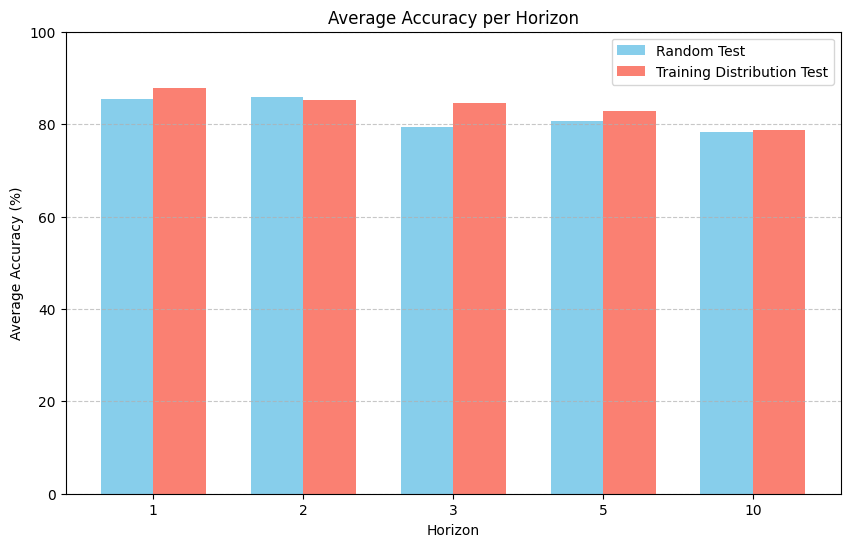

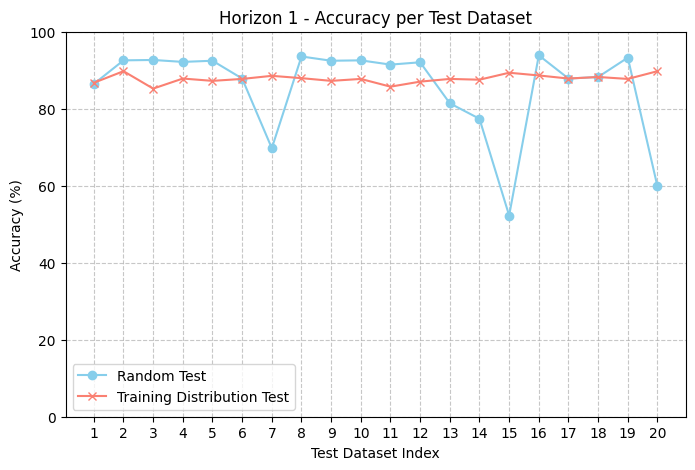

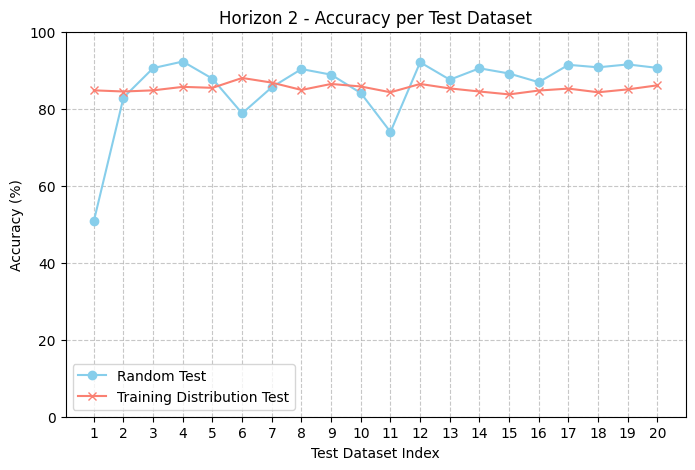

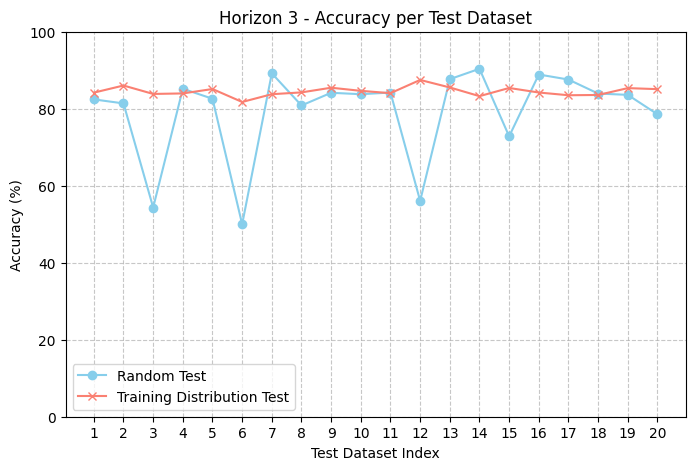

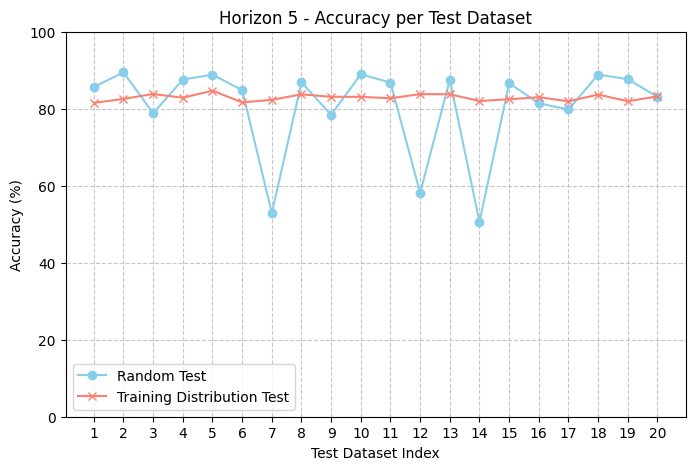

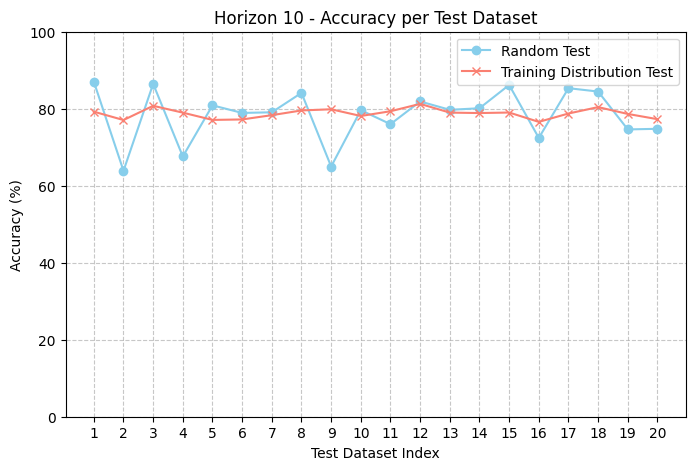

In [39]:
# -------------------------------
# Visualization for multi-horizon results
# -------------------------------

def plot_horizon_accuracies(all_results):
    horizons = sorted(all_results.keys())
    avg_acc_random = []
    avg_acc_train = []

    # Compute average accuracy per horizon for both test types (for bar plot)
    for h in horizons:
        _, res_random = all_results[h]["random"]
        _, res_train = all_results[h]["train"]

        avg_acc_random.append(np.mean([r[4] for r in res_random]))
        avg_acc_train.append(np.mean([r[4] for r in res_train]))

    # --- Bar Plot ---
    x = np.arange(len(horizons))  # positions
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, avg_acc_random, width, label='Random Test', color='skyblue')
    ax.bar(x + width/2, avg_acc_train, width, label='Training Distribution Test', color='salmon')

    ax.set_xlabel('Horizon')
    ax.set_ylabel('Average Accuracy (%)')
    ax.set_title('Average Accuracy per Horizon')
    ax.set_xticks(x)
    ax.set_xticklabels(horizons)
    ax.set_ylim(0, 100)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

    # --- Line Plot per Horizon ---
    for h in horizons:
        _, res_random = all_results[h]["random"]
        _, res_train = all_results[h]["train"]

        random_accs = [r[4] for r in res_random]
        train_accs = [r[4] for r in res_train]

        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(random_accs)+1), random_accs, marker='o', label='Random Test', color='skyblue')
        plt.plot(range(1, len(train_accs)+1), train_accs, marker='x', label='Training Distribution Test', color='salmon')

        plt.xlabel('Test Dataset Index')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Horizon {h} - Accuracy per Test Dataset')
        plt.ylim(0, 100)
        plt.xticks(range(1, len(random_accs)+1))
        plt.legend()
        plt.grid(linestyle='--', alpha=0.7)
        plt.show()


# -------------------------------
# Call the plotting function
# -------------------------------
plot_horizon_accuracies(all_results)
